In [1]:
import warnings
warnings.filterwarnings("ignore")

!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
import sklearn.metrics as metrics

In [3]:
#Preparation and cleaning of the data
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv', sep=',')#reading dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.columns = df.columns.str.replace(' ', '')  #remove empty characters from the columns

In [6]:
df.shape

(7043, 21)

In [7]:
df.duplicated().value_counts()  #get duplicated rows

False    7043
dtype: int64

In [8]:
dqr_num = df.describe() #data quality report for numeric variables
cardinality = df.apply(pd.Series.nunique)
dqr_num.loc['cardinality'] = cardinality[dqr_num.columns]
dqr_num.loc['missing'] = df.isnull().sum(axis = 0)
dqr_num = dqr_num.T
dqr_num

,count,mean,std,min,25%,50%,75%,max,cardinality,missing
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00,2.0,0.0
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00,73.0,0.0
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75,1585.0,0.0


In [9]:
categorical_columns= df.select_dtypes(exclude=["number"]).columns #data quality report for categorical features
formatter = "{0:.2f}"
listModeName=[]
list_mode=[]
print(f"{'Feature' : <16}{'Count' : ^10}{'Card' : ^10}{'Mode':^16}{'Mode Freq':^15}{'Mode(%)':^15}{'2nd Mode':^15}{'2nd Mode Freq':^15}{'2nd Mode(%)':^15}")
for i in range(len(categorical_columns)):
    listModeName.extend(df[categorical_columns[i]].value_counts().index.tolist())  
    list_mode.extend(df[categorical_columns[i]].value_counts())  
    print(f"{categorical_columns[i]: <16}{df[categorical_columns[i]].count(): ^10}{df[categorical_columns[i]].nunique(): ^10}{df[categorical_columns[i]].mode().values[0]: ^16}{df[categorical_columns[i]].value_counts().max(): ^15}{formatter.format((df[categorical_columns[i]].value_counts().max()/df[categorical_columns[i]].count())*100): ^15}{listModeName[1]: ^15}{list_mode[1]: ^15}{formatter.format((list_mode[1]/df[categorical_columns[i]].count())*100): ^15}")
    list_mode.clear() 
    listModeName.clear()

Feature           Count      Card         Mode         Mode Freq       Mode(%)       2nd Mode     2nd Mode Freq   2nd Mode(%)  
customerID         7043      7043      0002-ORFBO          1            0.01        0052-DCKON          1            0.01      
gender             7043       2           Male           3555           50.48         Female          3488           49.52     
Partner            7043       2            No            3641           51.70           Yes           3402           48.30     
Dependents         7043       2            No            4933           70.04           Yes           2110           29.96     
PhoneService       7043       2           Yes            6361           90.32           No             682           9.68      
MultipleLines      7043       3            No            3390           48.13           Yes           2971           42.18     
InternetService    7043       3       Fiber optic        3096           43.96           DSL           24

In [10]:
TotalCharges_median = df[df['TotalCharges'] != ' ']['TotalCharges'].apply(pd.to_numeric).median() #get the median without the empty strings
df["TotalCharges"].replace([' '], TotalCharges_median,inplace = True) #fil empty values with median
df['TotalCharges'] = df['TotalCharges'].apply(pd.to_numeric) #make the column type numeric 
print(TotalCharges_median, '\n')

1397.475 



Text(0, 0.5, 'Count')

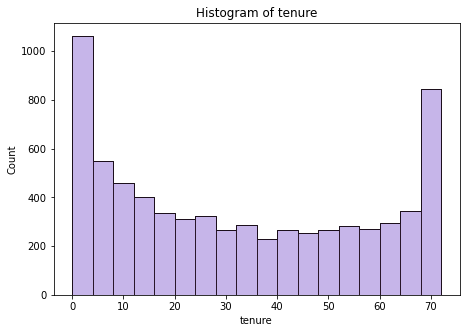

In [11]:
plt.figure(figsize=(16,5)) #data visualization
plt.subplot(1,2,1)
plt.hist(df['tenure'], color = 'lightblue', edgecolor = 'black',
         bins = int(180/10))

# seaborn histogram
sns.distplot(df['tenure'], hist=True, kde=False, 
             bins=int(180/10), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of tenure')
plt.xlabel('tenure')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

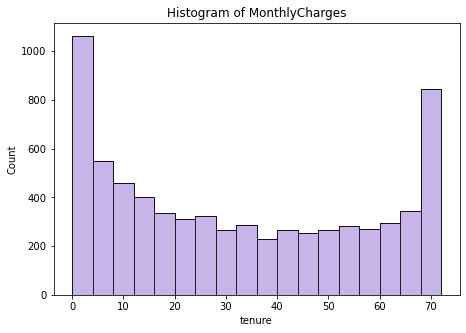

In [12]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(df['tenure'], color = 'lightblue', edgecolor = 'black',
         bins = int(180/10))

# seaborn histogram
sns.distplot(df['tenure'], hist=True, kde=False, 
             bins=int(180/10), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of MonthlyCharges')
plt.xlabel('tenure')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

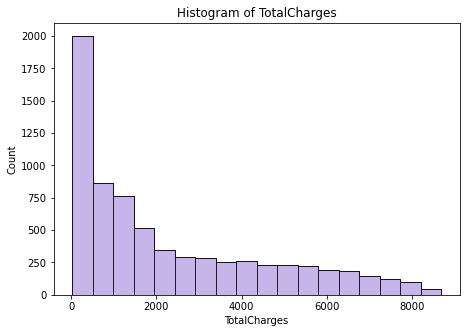

In [13]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(df['TotalCharges'], color = 'lightblue', edgecolor = 'black',
         bins = int(180/10))

# seaborn histogram
sns.distplot(df['TotalCharges'], hist=True, kde=False, 
             bins=int(180/10), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of TotalCharges')
plt.xlabel('TotalCharges')
plt.ylabel('Count')

Text(0.5, 1.0, 'Distribution of tenure by churn')

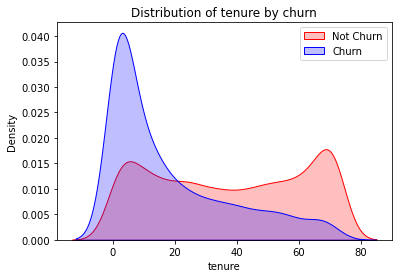

In [14]:
ax = sns.kdeplot(df.tenure[(df["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(df.tenure[(df["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('tenure')
ax.set_title('Distribution of tenure by churn')

No     5174
Yes    1869
Name: Churn, dtype: int64


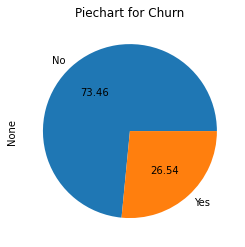

In [15]:
print(df["Churn"].value_counts())
df.groupby('Churn').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for Churn')
plt.show()

In [16]:
out=[]       #outlier detection by using IQR method
def iqr_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    print("Outliers:",out)
    
iqr_outliers(df['TotalCharges'])

Outliers: []


In [17]:
#encoding the features that have 2 values
binary_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'PhoneService', 'Churn'] 

for i in binary_cols: 
    if(i == 'gender'):
        df[i].replace({'Female': 0, 'Male': 1}, inplace=True) 
    else:
        df[i].replace({'No': 0, 'Yes': 1}, inplace=True) 

In [18]:
#encoding the features that have more than 2 values
encode_cols = ["MultipleLines", "InternetService", "OnlineSecurity", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod", "OnlineBackup"]
ohe = OneHotEncoder(sparse = False)

for i in encode_cols:
    df = pd.concat((df , pd.DataFrame(ohe.fit_transform(df[i].to_frame()),columns = str(i+"_") + np.sort(df[i].unique()))),axis = 1)
    df.drop(columns = [i],inplace = True)

In [19]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check',

In [20]:
df.columns = df.columns.str.replace(' ', '')  #remove empty characters on the columns which occured after the encoding
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'MultipleLines_No',
       'MultipleLines_Nophoneservice', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiberoptic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_Nointernetservice', 'OnlineSecurity_Yes',
       'DeviceProtection_No', 'DeviceProtection_Nointernetservice',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_Nointernetservice', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Nointernetservice', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_Nointernetservice',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_Oneyear',
       'Contract_Twoyear', 'PaymentMethod_Banktransfer(automatic)',
       'PaymentMethod_Creditcard(automatic)', 'PaymentMethod_Electroniccheck',
       'PaymentMethod_Mail

In [21]:
df.drop(columns = ["customerID"],inplace = True)  #remove the customerID column

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)  #max min normalization [0,1]
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,Contract_Month-to-month,Contract_Oneyear,Contract_Twoyear,PaymentMethod_Banktransfer(automatic),PaymentMethod_Creditcard(automatic),PaymentMethod_Electroniccheck,PaymentMethod_Mailedcheck,OnlineBackup_No,OnlineBackup_Nointernetservice,OnlineBackup_Yes
0,0.0,0.0,1.0,0.0,0.013889,0.0,1.0,0.115423,0.001275,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.472222,1.0,0.0,0.385075,0.215867,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.027778,1.0,1.0,0.354229,0.010310,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.625000,0.0,0.0,0.239303,0.210241,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.027778,1.0,1.0,0.521891,0.015330,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,0.333333,1.0,1.0,0.662189,0.227521,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7039,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,0.845274,0.847461,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7040,0.0,0.0,1.0,1.0,0.152778,0.0,1.0,0.112935,0.037809,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7041,1.0,1.0,1.0,0.0,0.055556,1.0,1.0,0.558706,0.033210,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


<AxesSubplot:>

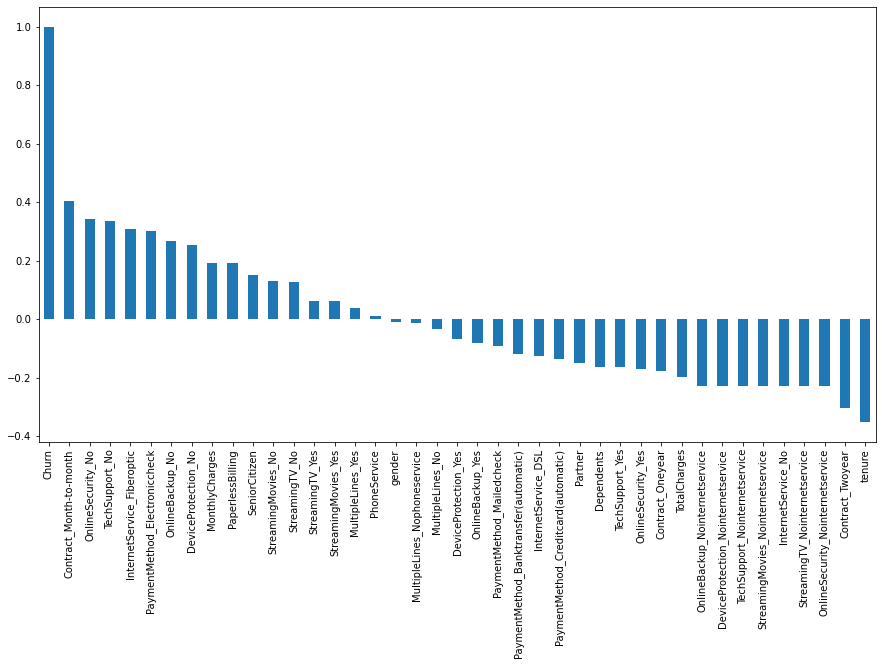

In [23]:
plt.figure(figsize=(15,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar') #Correlation of "Churn" with other features:

In [24]:
y = df.Churn.to_frame()  #preparing test and training dataframes in 90% training and 10% test
X = df.drop(columns = ["Churn"])
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.1, random_state = 10)

In [25]:
models = [LogisticRegression(), #models to be trained
          KNeighborsClassifier(),
          SGDClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          AdaBoostClassifier()
        ]

LogisticRegression() : 0.8056737588652483

Confusion Matrix : 
[[484  62]
 [ 75  84]]
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       546
         1.0       0.58      0.53      0.55       159

    accuracy                           0.81       705
   macro avg       0.72      0.71      0.71       705
weighted avg       0.80      0.81      0.80       705

Cross Validation mean: 0.8024631094233557



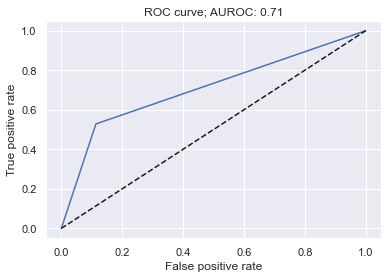

KNeighborsClassifier() : 0.75177304964539

Confusion Matrix : 
[[462  84]
 [ 91  68]]
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       546
         1.0       0.45      0.43      0.44       159

    accuracy                           0.75       705
   macro avg       0.64      0.64      0.64       705
weighted avg       0.75      0.75      0.75       705

Cross Validation mean: 0.7600206318118617



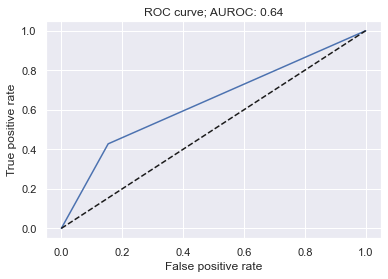

SGDClassifier() : 0.8099290780141843

Confusion Matrix : 
[[501  45]
 [ 89  70]]
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       546
         1.0       0.61      0.44      0.51       159

    accuracy                           0.81       705
   macro avg       0.73      0.68      0.70       705
weighted avg       0.79      0.81      0.80       705

Cross Validation mean: 0.7945766740921255



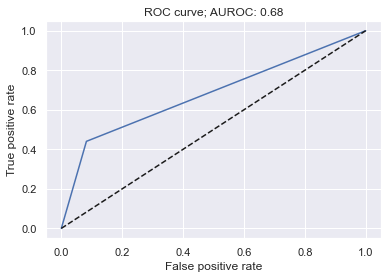

DecisionTreeClassifier() : 0.7361702127659574

Confusion Matrix : 
[[431 115]
 [ 71  88]]
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82       546
         1.0       0.43      0.55      0.49       159

    accuracy                           0.74       705
   macro avg       0.65      0.67      0.65       705
weighted avg       0.76      0.74      0.75       705

Cross Validation mean: 0.730362402260529



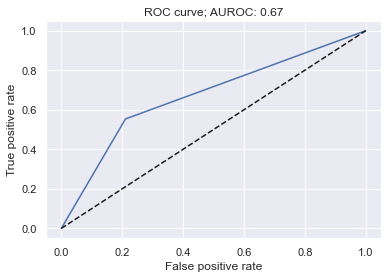

RandomForestClassifier() : 0.8127659574468085

Confusion Matrix : 
[[490  56]
 [ 76  83]]
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88       546
         1.0       0.60      0.52      0.56       159

    accuracy                           0.81       705
   macro avg       0.73      0.71      0.72       705
weighted avg       0.81      0.81      0.81       705

Cross Validation mean: 0.7871554512336727



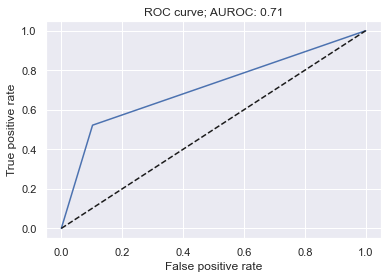

SVC() : 0.7943262411347518

Confusion Matrix : 
[[490  56]
 [ 89  70]]
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       546
         1.0       0.56      0.44      0.49       159

    accuracy                           0.79       705
   macro avg       0.70      0.67      0.68       705
weighted avg       0.78      0.79      0.79       705

Cross Validation mean: 0.7983616646981725



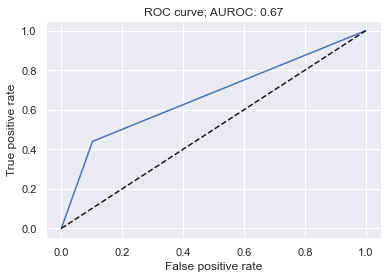

AdaBoostClassifier() : 0.8042553191489362

Confusion Matrix : 
[[483  63]
 [ 75  84]]
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       546
         1.0       0.57      0.53      0.55       159

    accuracy                           0.80       705
   macro avg       0.72      0.71      0.71       705
weighted avg       0.80      0.80      0.80       705

Cross Validation mean: 0.8053044687308445



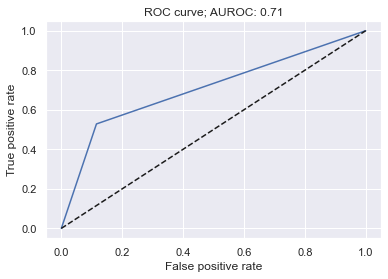

In [27]:
for i, model in enumerate(models):        #90/10 and 10-fold cross validation 
    model.fit(X_train, y_train)
    print(models[i], ':', model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    #acc = accuracy_score(y_test, y_pred)
    print()
    print("Confusion Matrix : ")
    print(conf_mat)
    print(classification_report(y_test, y_pred))
    print('Cross Validation mean:',(cross_val_score(model, X_train, y_train, cv=10, n_jobs=2, scoring = 'accuracy').mean()))
    print()
        
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    sns.set()
    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    AUROC = np.round(roc_auc_score(y_test, y_pred), 2)
    plt.title(f'ROC curve; AUROC: {AUROC}');
    plt.show()

In [28]:
sm = SMOTE() #oversampling to overcome imbalanced class problem
X_sm , y_sm = sm.fit_resample(X, y)
y_sm.Churn.value_counts()

0.0    5174
1.0    5174
Name: Churn, dtype: int64

LogisticRegression() : 0.7681159420289855

Confusion Matrix : 
[[397 137]
 [103 398]]
              precision    recall  f1-score   support

         0.0       0.79      0.74      0.77       534
         1.0       0.74      0.79      0.77       501

    accuracy                           0.77      1035
   macro avg       0.77      0.77      0.77      1035
weighted avg       0.77      0.77      0.77      1035

Cross Validation mean: 0.7771952490054075



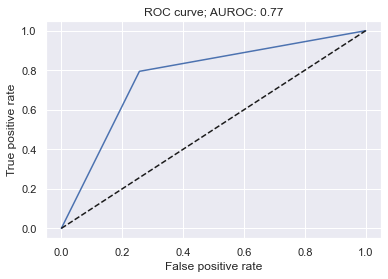

KNeighborsClassifier() : 0.7816425120772947

Confusion Matrix : 
[[356 178]
 [ 48 453]]
              precision    recall  f1-score   support

         0.0       0.88      0.67      0.76       534
         1.0       0.72      0.90      0.80       501

    accuracy                           0.78      1035
   macro avg       0.80      0.79      0.78      1035
weighted avg       0.80      0.78      0.78      1035

Cross Validation mean: 0.7885754392111488



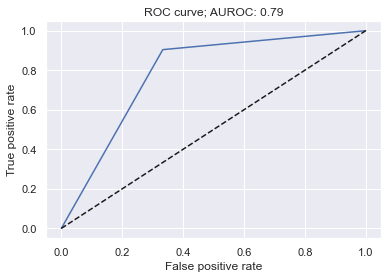

SGDClassifier() : 0.7594202898550725

Confusion Matrix : 
[[391 143]
 [106 395]]
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       534
         1.0       0.73      0.79      0.76       501

    accuracy                           0.76      1035
   macro avg       0.76      0.76      0.76      1035
weighted avg       0.76      0.76      0.76      1035

Cross Validation mean: 0.766029190081273



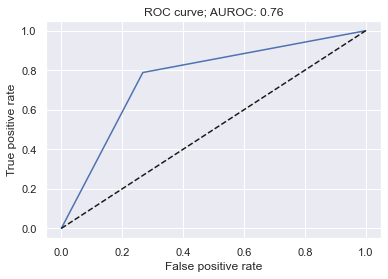

DecisionTreeClassifier() : 0.7816425120772947

Confusion Matrix : 
[[415 119]
 [107 394]]
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       534
         1.0       0.77      0.79      0.78       501

    accuracy                           0.78      1035
   macro avg       0.78      0.78      0.78      1035
weighted avg       0.78      0.78      0.78      1035

Cross Validation mean: 0.7818094439040582



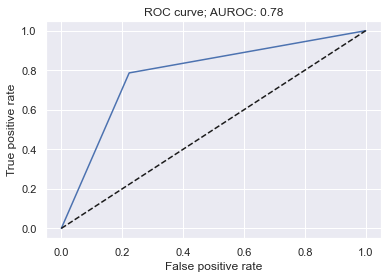

RandomForestClassifier() : 0.842512077294686

Confusion Matrix : 
[[446  88]
 [ 75 426]]
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       534
         1.0       0.83      0.85      0.84       501

    accuracy                           0.84      1035
   macro avg       0.84      0.84      0.84      1035
weighted avg       0.84      0.84      0.84      1035

Cross Validation mean: 0.854396836665545



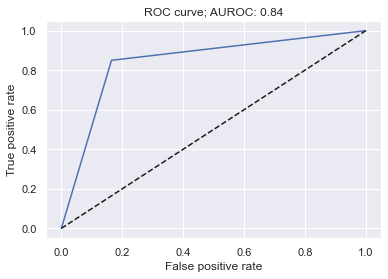

SVC() : 0.7932367149758454

Confusion Matrix : 
[[415 119]
 [ 95 406]]
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80       534
         1.0       0.77      0.81      0.79       501

    accuracy                           0.79      1035
   macro avg       0.79      0.79      0.79      1035
weighted avg       0.79      0.79      0.79      1035

Cross Validation mean: 0.8113393923189334



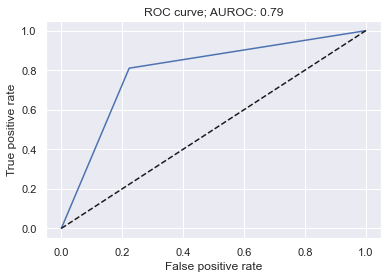

AdaBoostClassifier() : 0.8135265700483092

Confusion Matrix : 
[[417 117]
 [ 76 425]]
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81       534
         1.0       0.78      0.85      0.81       501

    accuracy                           0.81      1035
   macro avg       0.81      0.81      0.81      1035
weighted avg       0.82      0.81      0.81      1035

Cross Validation mean: 0.8160648017960291



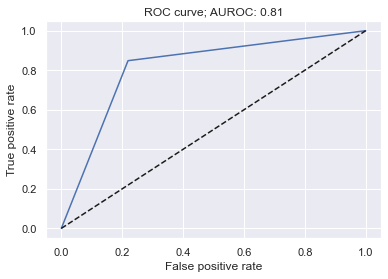

In [29]:
X_train_sm , X_test_sm , y_train_sm , y_test_sm = train_test_split(X_sm, y_sm, test_size = 0.1, random_state = 10)
  #same process with oversampled dataset
for i, model in enumerate(models):
    model.fit(X_train_sm, y_train_sm)
    print(models[i], ':', model.score(X_test_sm, y_test_sm))
    y_pred_sm = model.predict(X_test_sm)
    conf_mat = confusion_matrix(y_test_sm, y_pred_sm)
  
    print()
    print("Confusion Matrix : ")
    print(conf_mat)
    print(classification_report(y_test_sm, y_pred_sm))
    print('Cross Validation mean:',(cross_val_score(model, X_train_sm, y_train_sm, cv=10, n_jobs=2, scoring = 'accuracy').mean()))
    print()
    
    fpr, tpr, thresholds = roc_curve(y_test_sm, y_pred_sm)
    sns.set()
    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    AUROC = np.round(roc_auc_score(y_test_sm, y_pred_sm), 2)
    plt.title(f'ROC curve; AUROC: {AUROC}');
    plt.show()